In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython.core.display import display, HTML
import pandas as pd
%reload_ext autoreload
%autoreload 1
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth',100)    

display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from itertools import combinations, takewhile
import collections
import pandas as pd
import numpy as np
import os

from simhash import Simhash, SimhashIndex

sns.set()

from Utils.UtilsViz import *
from Utils.UtilsGeoViz import *

print(sys.version)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


In [2]:
fpath = os.path.join(os.getcwd(), "temp.csv")
tweets_df = pd.read_csv(fpath, index_col="Unnamed: 0")
display(
    tweets_df.shape,
    tweets_df.head()
)

(1048947, 20)

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned
0,8.778927e+17,RT @ArkansasBlog: Study: States with concealed carry laws experience rise in violent crime. http...,NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,1.550783e+08,Lake Man,1554.0,56574.0,95959.0,2577.0,NaN,0.0,[],False,0.0,False,17131180,Arkansas Blog,[]
1,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,7.159992e+06,Annie Williams,22.0,167.0,417.0,87.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
2,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:01 +0000 2017,8.271887e+17,Indivisible9IL,264.0,111.0,342.0,231.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
3,8.778927e+17,"IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...",NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,8.313191e+17,Indivisible Illinois,1027.0,1626.0,982.0,267.0,NaN,0.0,[],False,0.0,False,NaN,NaN,[]
4,8.778927e+17,Day 1 of Chicago Summit: Gregory Touhill delivers keynote on Cybersecurity=Risk Management #ISMG...,NaN,NaN,Thu Jun 22 14:15:02 +0000 2017,3.998460e+07,ISMG Network News,2395.0,119.0,12833.0,960.0,NaN,0.0,"[Row(indices=[91, 103], text='ISMGSummits'), Row(indices=[104, 112], text='infosec')]",False,0.0,False,NaN,NaN,"['ISMGSummits', 'infosec']"


In [3]:
from ast import literal_eval

def le(row):
    if row is np.NaN:
        return []
    else:
        return literal_eval(row)

tweets_df['hashtags_cleaned']=tweets_df['hashtags_cleaned'].apply(le)

In [4]:
tweets_df["text"].fillna(value="", inplace=True)
tweets_df["text_len"] = tweets_df["text"].apply(len)

# Q1 - Identify tweets related to UChicago and 3-4 universities of your choice

In [5]:
uc_favored_tags = ["uchicago", "uchearing", "universityofchicago", "pritzkerschoolofmedicine",
                   "uofc", "maroonmade", "chicagobooth"]
nw_favored_tags = ["northwestern"]
upenn_favored_tags = ["upenn", "penn", "uofpenn", "universityofpennsylvania", "pennlaw", "upennhearing"]
uic_favored_tags = ["UIC", "UICProud"]
mit_favored_tags = ["MIT"]
stanford_favored_tags = ["stanford"]

def is_stanford_tweet(row):
    if row is np.NaN:
        return False
    for ftag in stanford_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_upenn_tweet(row):
    if row is np.NaN:
        return False
    for ftag in upenn_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_nw_tweet(row):
    if row is np.NaN:
        return False
    for ftag in nw_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_uc_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uc_favored_tags:
        for tag in row:
            if ftag.lower() in tag.lower():
                return True
    return False

def is_uic_tweet(row):
    if row is np.NaN:
        return False
    for ftag in uic_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

def is_mit_tweet(row):
    if row is np.NaN:
        return False
    for ftag in mit_favored_tags:
        for tag in row:
            if ftag.lower() == tag.lower():
                return True
    return False

tweets_df["mit_tweet"] = tweets_df["hashtags_cleaned"].apply(is_mit_tweet)
tweets_df["stanford_tweet"] = tweets_df["hashtags_cleaned"].apply(is_stanford_tweet)
tweets_df["nw_tweet"] = tweets_df["hashtags_cleaned"].apply(is_nw_tweet)
tweets_df["upenn_tweet"] = tweets_df["hashtags_cleaned"].apply(is_upenn_tweet)
tweets_df["uc_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uc_tweet)
tweets_df["uic_tweet"] = tweets_df["hashtags_cleaned"].apply(is_uic_tweet)

cols = ["uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet"]

def is_uni_tweet(row):
    for col in cols:
        if row[col]:
            return True
    else:
        return False

tweets_df["uni_tweet"] = tweets_df[cols].apply(is_uni_tweet, axis=1)

def is_uni_tweet2(row):
    for col in cols:
        if row[col]:
            return col[0:-6]
    else:
        return ""

tweets_df["uni_tweet_name"] = tweets_df[cols].apply(is_uni_tweet2, axis=1)

(133, 3)

(93, 3)

(88, 3)

(1021, 3)

(818, 3)

(214, 3)

(1048947,)

(1048947, 29)

Make a subset data set that only picks tweets related to universities we're analysing.

In [6]:
uni_df = tweets_df[(tweets_df["uni_tweet"]==True)]

Let's just quickly make a Time dimension for ease of use later on.

In [50]:
uni_df["created_at"] = pd.to_datetime(uni_df['created_at'])

In [51]:
uni_df['created_month'] = uni_df['created_at'].map(lambda x: x.month)
uni_df['created_year'] = uni_df['created_at'].map(lambda x: x.year)
uni_df['created_date'] = uni_df['created_at'].map(lambda x: x.day)
uni_df['created_dayofweek'] = uni_df['created_at'].map(lambda x: x.weekday_name)

In [7]:
uni_df.shape

(2350, 29)

# Q2 - Identify the most prolific / influential Twitterers
1. By message volume
1. By message retweet
1. How much are they tweeting about the Universities vs. other topics? 

In [8]:
uni_df.head()

,id_str,text,in_reply_to_status_id_str,in_reply_to_user_id_str,created_at,user_id_str,user_name,user_followers_count,user_favourites_count,user_statuses_count,user_friends_count,coordinates,favorite_count,entities_hashtags,favorited,retweet_count,retweeted,retweeted_status_user_id_str,retweeted_status_user_name,hashtags_cleaned,text_len,mit_tweet,stanford_tweet,nw_tweet,upenn_tweet,uc_tweet,uic_tweet,uni_tweet,uni_tweet_name
348,8.778933e+17,RT @OriginalMcGill3: #AGTG EXTREMELY HONORED AND BLESSED TO RECIEVE AN OFFER FROM STANFORD UNIVE...,NaN,NaN,Thu Jun 22 14:17:26 +0000 2017,24333184.0,Gabe,85.0,385.0,152.0,213.0,NaN,0.0,"[Row(indices=[21, 26], text='AGTG'), Row(indices=[103, 114], text='GoStanford')]",False,0.0,False,1104434276,Jonathan McGill,"[AGTG, GoStanford]",140,False,True,False,False,False,False,True,stanford
373,8.778933e+17,New algorithm generates folding patterns to produce any #3-D origami structure #MIT... https://t...,NaN,NaN,Thu Jun 22 14:17:39 +0000 2017,588604189.0,Technolizer,880.0,0.0,117346.0,381.0,NaN,0.0,"[Row(indices=[79, 83], text='MIT')]",False,0.0,False,NaN,NaN,[MIT],134,True,False,False,False,False,False,True,mit
443,8.778935e+17,RT @MirandaWeinberg: Morning! Today I'll be live from #UPennHearing on behalf of @GETUPgrads &am...,NaN,NaN,Thu Jun 22 14:18:07 +0000 2017,274415582.0,Danielle Hanley,131.0,637.0,577.0,288.0,NaN,0.0,"[Row(indices=[54, 67], text='UPennHearing'), Row(indices=[133, 143], text='UChearing')]",False,0.0,False,1158927727,Miranda Weinberg,"[UPennHearing, UChearing]",144,False,False,False,True,True,False,True,uc
473,8.778935e+17,#Stanford Scientists #Discover a #Way to #Convert #Carbon #Dioxide into #Clean #Burning #Ethanol...,NaN,NaN,Thu Jun 22 14:18:19 +0000 2017,45817618.0,Ivan Kulikov,449.0,528.0,9451.0,358.0,NaN,0.0,"[Row(indices=[0, 9], text='Stanford'), Row(indices=[21, 30], text='Discover'), Row(indices=[33, ...",False,0.0,False,NaN,NaN,"[Stanford, Discover, Way, Convert, Carbon, Dioxide, Clean, Burning, Ethanol]",120,False,True,False,False,False,False,True,stanford
741,8.778940e+17,https://t.co/3fR9KmELE1 5 Life Hacks und Tricks mit Ballons | Tommy Tv #video #life #hacks #und ...,NaN,NaN,Thu Jun 22 14:20:09 +0000 2017,366674576.0,HotVideo Deutschland,369.0,0.0,47474.0,0.0,NaN,0.0,"[Row(indices=[71, 77], text='video'), Row(indices=[78, 83], text='life'), Row(indices=[84, 90], ...",False,0.0,False,NaN,NaN,"[video, life, hacks, und, tricks, mit, ballons, tommy]",124,True,False,False,False,False,False,True,mit


Can we identify Retweets?

In [9]:
uni_df["retweeted_status_user_id_str"].count()

975

## Most active users

How many users do we have in this glorious subsample?

In [10]:
uni_df["user_id_str"].unique().shape

(1540,)

### Message Volume

In [11]:
user_grp = uni_df[["id_str", "user_id_str", "user_name"]].groupby(by=["user_name"], as_index=False).count()
user_grp.reset_index(drop=True, inplace=True)
user_grp.head()

,user_name,id_str,user_id_str
0,#JamalVarney,1,1
1,#Programmer Bot,4,4
2,#Proud Deplorable,1,1
3,#W.W.J.W,1,1
4,#idampan idamariapan,1,1


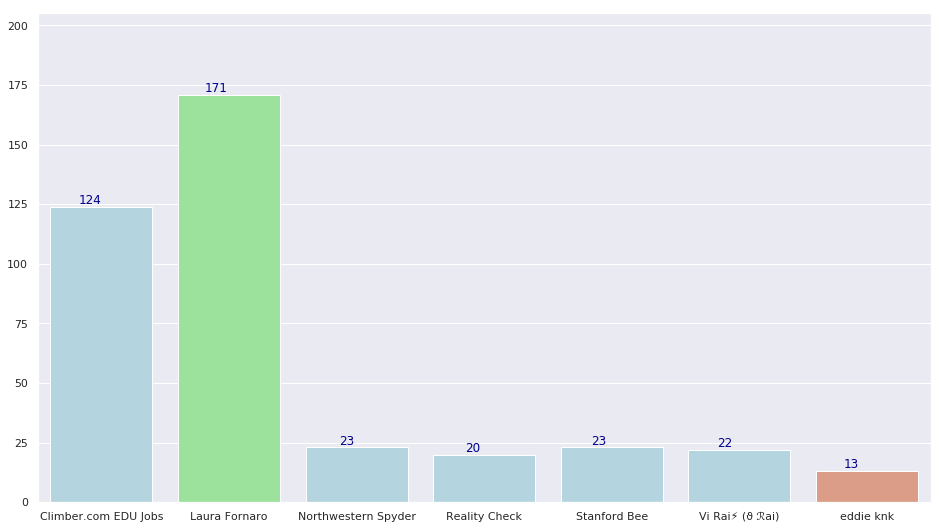

In [12]:
user_subset = user_grp[user_grp["id_str"] > 10]
user_subset.reset_index(drop=True, inplace=True)
f, ax = plt.subplots(1, 1, figsize=(16,9))
plot_bar(data=user_subset, x="user_name", y="id_str", ax=ax)

[USERNAME] Seems to be the most active user with several tweets

### Message Retweet

###### <font color=red> NOTE : CHANGE DATAFRAME TO uni_df WHEN RUNNING ONLINE </font>

In [13]:
user_rt_grp = tweets_df[["user_name", "retweet_count"]].groupby(by=["user_name"], as_index=False).sum()
user_rt_grp.reset_index(drop=True, inplace=True)
display(user_rt_grp.head())

# user_rt_subset = user_rt_grp[user_rt_grp["retweet_count"] > 10]
# user_rt_subset.reset_index(drop=True, inplace=True)
# display(user_rt_grp[user_rt_grp["retweet_count"] > 10])

,user_name,retweet_count
0,Anita El-Hara,0.0
1,Anneliese Kearney,0.0
2,BigDadio,0.0
3,Dusty Jorgenson,0.0
4,Edna Adelberg,0.0


In [14]:
# f, ax = plt.subplots(1, 1, figsize=(16,9))
# plot_bar(data=user_rt_subset, x="user_name", y="retweet_count", ax=ax)

### How much are they tweeting about the Universities vs. other topics?

In [15]:
prolific_users = user_subset["user_name"].unique()

In [16]:
cols = ["id_str", "user_id_str", "text", "user_name", "hashtags_cleaned", "uc_tweet", "uic_tweet", "mit_tweet", "stanford_tweet", "upenn_tweet", "nw_tweet", "uni_tweet"]
uvnu_df = tweets_df[tweets_df["user_name"].isin(prolific_users)][cols]
def tmpfun(row):
    if row:
        return 1
    else:
        return 0
uvnu_df["uni_tweet"] = uvnu_df["uni_tweet"].apply(tmpfun)
uvnu_df.shape

(514, 12)

In [17]:
tmp_df = uvnu_df[["user_name", "uni_tweet"]].groupby(by="user_name", as_index=False).agg(["sum", "count"])
tmp_df.columns = ["uni_tweets", "total_tweets"]
tmp_df.reset_index(drop=False, inplace=True)
tmp_df["ratio"] = tmp_df["uni_tweets"] / tmp_df["total_tweets"]
tmp_df

,user_name,uni_tweets,total_tweets,ratio
0,Climber.com EDU Jobs,124,192,0.645833
1,Laura Fornaro,171,171,1.000000
2,Northwestern Spyder,23,23,1.000000
3,Reality Check,20,33,0.606061
4,Stanford Bee,23,23,1.000000
5,Vi Rai⚡️ (ϑ ℛai),22,59,0.372881
6,eddie knk,13,13,1.000000


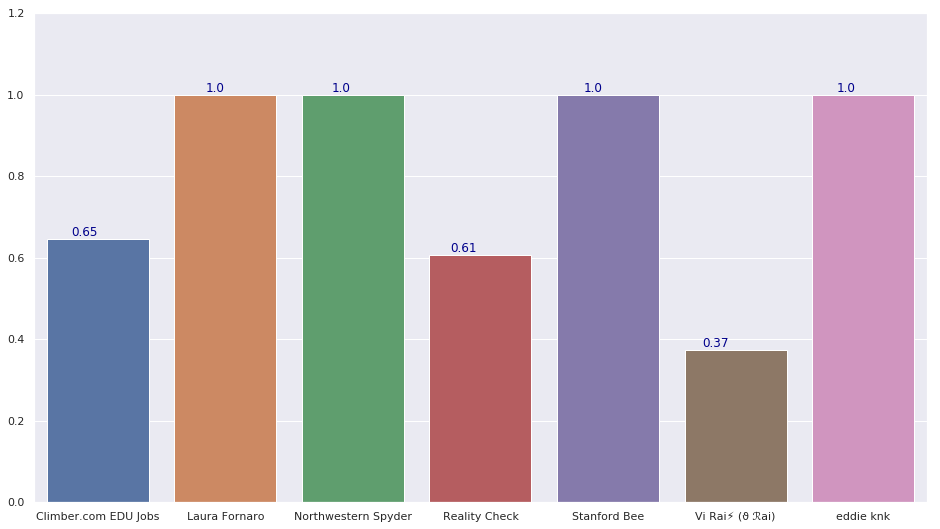

In [18]:
f, ax = plt.subplots(1,1,figsize=(16,9))
plot_bar(data=tmp_df, x="user_name", y="ratio", ax=ax, highlight_max_min=False)

## Where are these Twitterers located?
-  For UChicago
-  For other universities
-  Do you see any relationship between university locations and Twitterers’ locations?
-  Visualize the relationships

##### <font color="red">ToDo</font>

## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
Visualize the trends

##### <font color="red">Re-tweets</font>

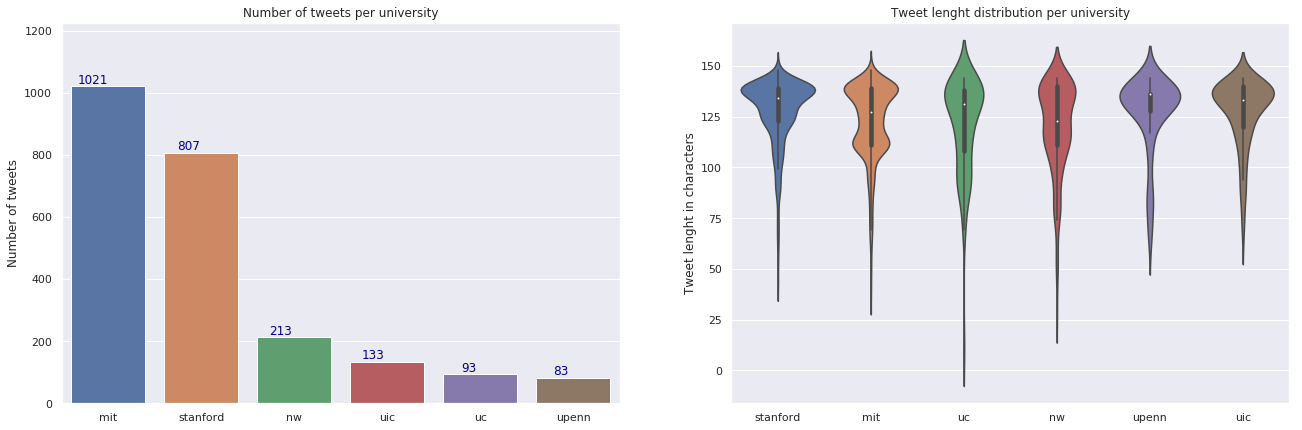

In [48]:
f, ax = plt.subplots(1,2,figsize=(22,7))

uni_counts = uni_df["uni_tweet_name"].value_counts().to_frame()
uni_counts.reset_index(drop=False, inplace=True)
uni_counts.columns = ["university", "num_tweets"]
plot_bar(x="university", y="num_tweets", data=uni_counts, ax=ax[0], highlight_max_min=False,
        title="Number of tweets per university", ylabel="Number of tweets")

sns.violinplot(data=uni_df, x="uni_tweet_name", y="text_len", ax=ax[1] )
t = ax[1].set(title="Tweet lenght distribution per university", ylabel="Tweet lenght in characters", xlabel="")

## What are the timelines of these tweets? Do you see significant peaks and valleys?
Do you see data collection gaps?

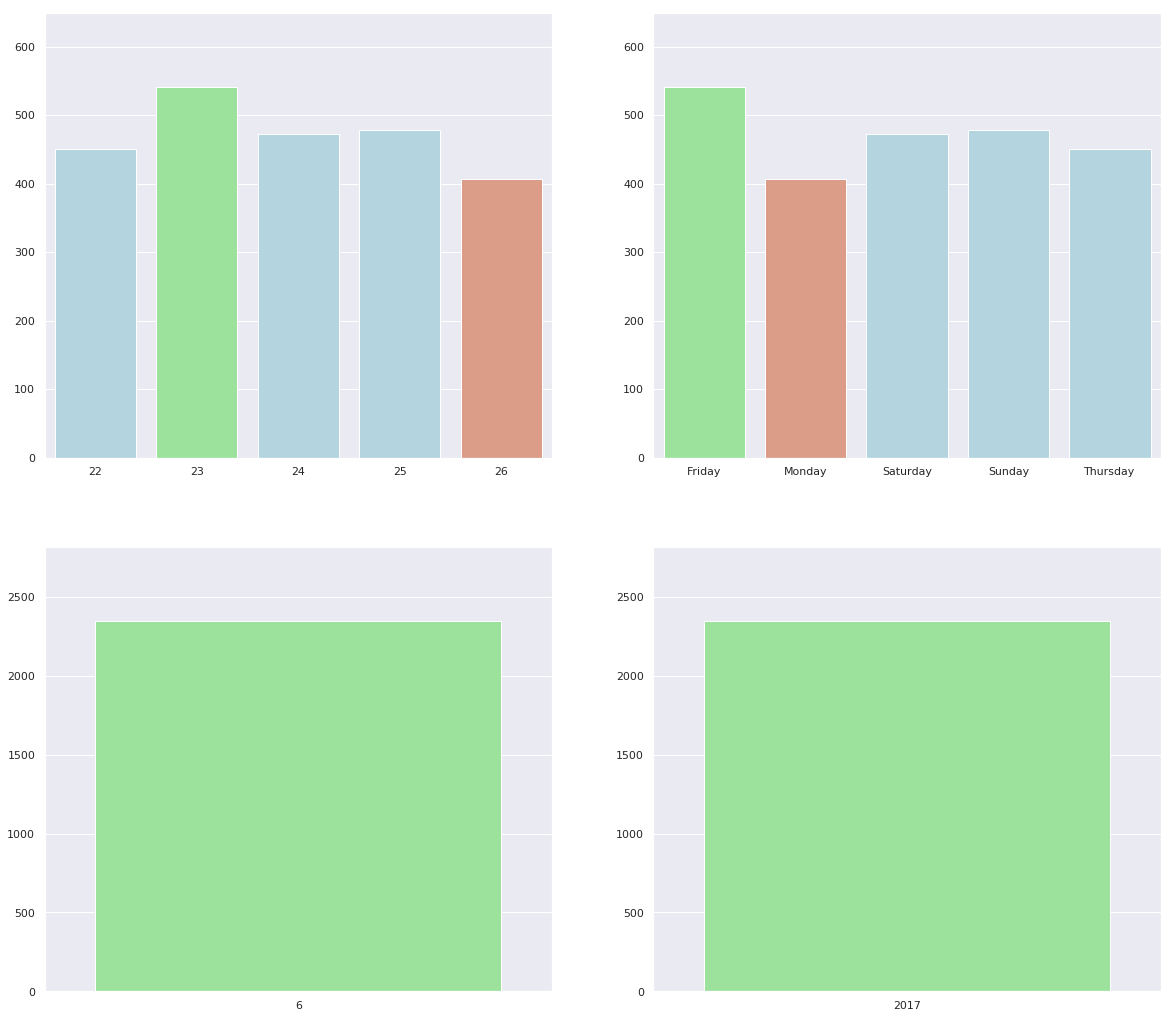

In [52]:
uni_df_date_grp = uni_df[["id_str", "created_date"]].groupby(by="created_date", as_index=False).count()
uni_df_dayofweek_grp = uni_df[["id_str", "created_dayofweek"]].groupby(by="created_dayofweek", as_index=False).count()
uni_df_month_grp = uni_df[["id_str", "created_month"]].groupby(by="created_month", as_index=False).count()
uni_df_year_grp = uni_df[["id_str", "created_year"]].groupby(by="created_year", as_index=False).count()

f, ax = plt.subplots(2,2,figsize=(20,18))
plot_bar(data=uni_df_date_grp, x="created_date", y="id_str", ax=ax[0][0], annot=False)
plot_bar(data=uni_df_dayofweek_grp, x="created_dayofweek", y="id_str", ax=ax[0][1], annot=False)
plot_bar(data=uni_df_month_grp, x="created_month", y="id_str", ax=ax[1][0], annot=False)
plot_bar(data=uni_df_year_grp, x="created_year", y="id_str", ax=ax[1][1], annot=False)

## How unique are the messages for each of these universities?
-  Are they mostly unique? Or mostly people are just copy-pasting the same text?
-  You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
-  Visualize message duplication (for each university – not between the universities)

In [54]:
tweets_df["text"].head()

0    RT @ArkansasBlog: Study: States with concealed carry laws experience rise in violent crime. http...
1    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
2    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
3    IL Healthcare Truth Tour: Heal Don't Repeal! 6/22 2:30PM Federal Plaza, Chicago. Mobile billboar...
4    Day 1 of Chicago Summit: Gregory Touhill delivers keynote on Cybersecurity=Risk Management #ISMG...
Name: text, dtype: object

We will need to remove all the Re-tweets to ensure we aren't inordinately biased towards some tweets.

In [67]:
rows_to_drop = uni_df[~uni_df["retweeted_status_user_id_str"].isna()].index
# Drop all the rows with retweets
unique_uni_tweets_df = uni_df.drop(rows_to_drop, axis=0)

(1375, 33)

In [73]:
uc_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uc_tweet"]==True]["text"]
uic_tweets = unique_uni_tweets_df[unique_uni_tweets_df["uic_tweet"]==True]["text"]
upenn_tweets = unique_uni_tweets_df[unique_uni_tweets_df["upenn_tweet"]==True]["text"]
nw_tweets = unique_uni_tweets_df[unique_uni_tweets_df["nw_tweet"]==True]["text"]
stanford_tweets = unique_uni_tweets_df[unique_uni_tweets_df["stanford_tweet"]==True]["text"]
mit_tweets = unique_uni_tweets_df[unique_uni_tweets_df["mit_tweet"]==True]["text"]

Some helper functions

In [85]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

def get_ratios(df):
    data = df.to_dict()
    objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
    index = SimhashIndex(objs, k=3)
    list_all = []
    for i in range(0,len(data)):
        s1 = list(data.values())[i]
        s2 = Simhash(get_features(s1))
        list_all.append(len(index.get_near_dups(s2)))
    a = [0 if i == 1 else 1 for i in list_all]
    duplicate = sum(a)
    unique = len(a)-sum(a)
    return duplicate, unique

In [88]:
uc_dup, uc_unique = get_ratios(uc_tweets)
uic_dup, uic_unique = get_ratios(uic_tweets)
upenn_dup, upenn_unique = get_ratios(upenn_tweets)
nw_dup, nw_unique = get_ratios(nw_tweets)
stanford_dup, stanford_unique = get_ratios(stanford_tweets)
mit_dup, mit_unique = get_ratios(mit_tweets)

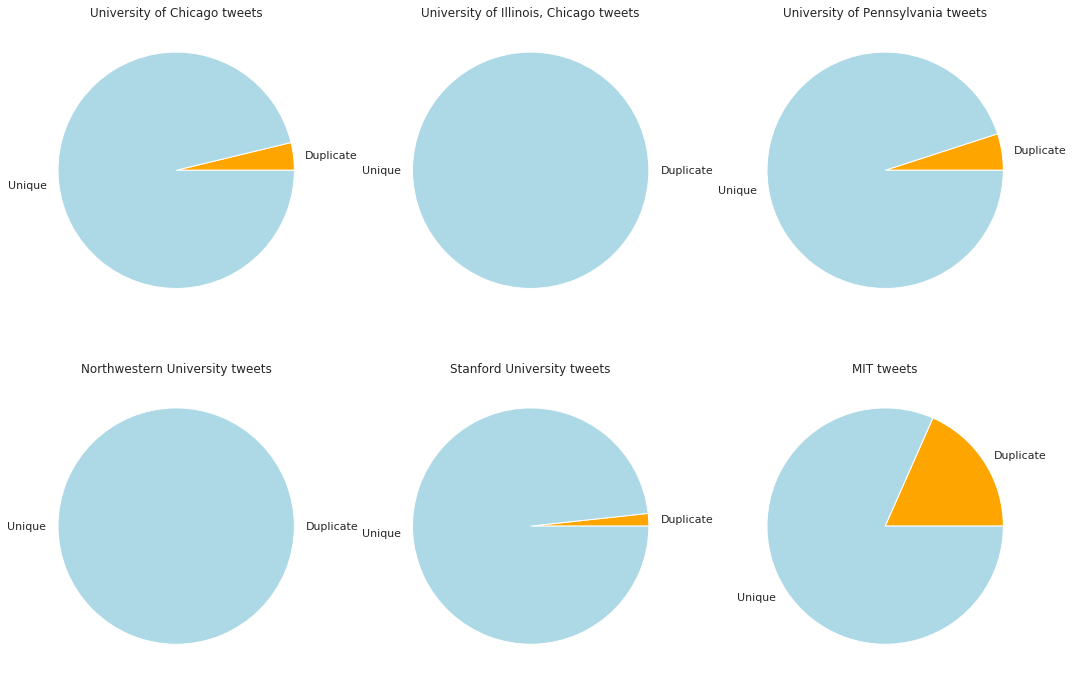

In [139]:
labels = ['Duplicate', 'Unique']
colors = ['orange','lightblue']
f, ax = plt.subplots(2, 3, figsize=(18, 12))
plot_pie(values=[uc_dup, uc_unique], labels=labels, colors=colors, ax=ax[0][0])
ax[0][0].set(title="University of Chicago tweets")

plot_pie(values=[uic_dup, uic_unique], labels=labels, colors=colors, ax=ax[0][1])
ax[0][1].set(title="University of Illinois, Chicago tweets")

plot_pie(values=[upenn_dup, upenn_unique], labels=labels, colors=colors, ax=ax[0][2])
ax[0][2].set(title="University of Pennsylvania tweets")

plot_pie(values=[nw_dup, nw_unique], labels=labels, colors=colors, ax=ax[1][0])
ax[1][0].set(title="Northwestern University tweets")

plot_pie(values=[stanford_dup, stanford_unique], labels=labels, colors=colors, ax=ax[1][1])
ax[1][1].set(title="Stanford University tweets")

plot_pie(values=[mit_dup, mit_unique], labels=labels, colors=colors, ax=ax[1][2])
t = ax[1][2].set(title="MIT tweets")

